<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

/bin/bash: line 1: apt-get: command not found


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


**Part 3 - Computing the QDF**

Having demonstrated how to construct the finite element approximation of the CDF $\mathsf{F}_Y$ and PDF $\mathsf{f}_Y$ of a random function $Y(\mathbf{x})$ we now develop a means to obtain the inverse CDF $\mathsf{F}^{-1}_Y(p) := \mathsf{Q}_Y(p)$ also known as the quantile density function (QDF). When estimating available potential energy (APE) of a density field, the QDF of domain height is used to account for how much of this field is located at each height and thus forms an essential component of the calculation which motivates this work (cf. [Winters et al. JFM. (1995)](https://doi.org/10.1017/S002211209500125X) and [Tseng and Ferziger. Phys. Fluids. (2001)](https://doi.org/10.1063/1.1358307)). Equally when developing turbulence closures for PDF methods, the inverse CDF is required to obtain the mapping between the turbulent field and a Gaussian random field ([Pope. S.B. Theoret. Comput. Fluid Dynamics. (1991)](https://doi.org/10.1007/BF00271466))

To demonstrate our method of constructing the QDF, we choose the function $Y(x_1) = x_1$ on the interval $x_1 \in [0,1]$. To further simplify the presentation we will use the *Ptp* class (imported below) to obtain the CDF of this function.

In [2]:
from numdf import Ptp
import numpy as np
from firedrake import *
from firedrake.__future__ import interpolate

We begin by creating an instance of the *Ptp* class by specifying the physical domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 and Part2 of the explanatory notebooks a discontinuous piecewise linear 'DG1' finite element space is selected by default for the CDF.

In [3]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (0, 1)}, Omega_Y = {'Y': (0, 1)}, n_elements=3)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain, its range, and generate its CDF and PDF by calling the fit method here (with an intentinally small quadrature degree)

In [4]:
# Extract the coordinates
x1 = ptp.x_coords()
density = ptp.fit(Y = x1, Range_Y={'Y_min': 0, 'Y_max': 1}, quadrature_degree=10)

Once fitted we can then plot the CDF functions by calling the plot method

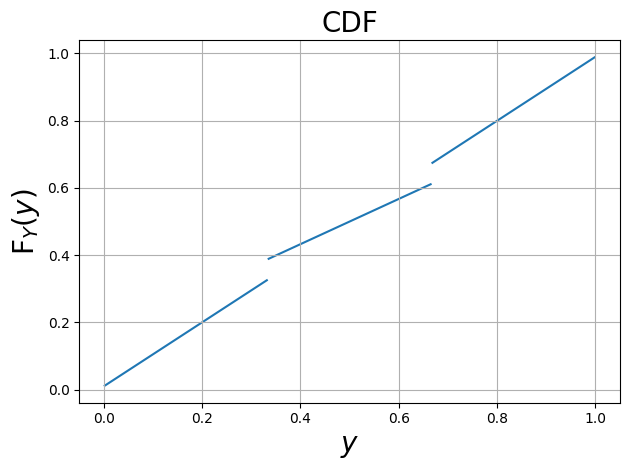

In [5]:
density.plot(function='CDF')

By choosing a small number of elements and a similarly low order quadrature we have intentionally generated a poor approximation of the CDF, which although non-decreasing is discontinous between elements. Importantly this highlights that the CDF can contain well mixed regions for which one value of $y*$ has associated to it a range of probabilities $\Omega^*_Y = [\text{min}(\mathsf{F}_Y(y*)),\text{max}(\mathsf{F}_Y(y*))]$. To obtain a consistent QDF we must therefore construct a function capable of mapping $\mathsf{Q}_Y : p \to \Omega^*_Y$. 

To obtain such a function we use the fact that $\mathsf{F}(y)$ is discontinuous piecewise linear function, by letting its discontinuities determine the mesh spacing of the non-uniform mesh $\Omega_p$, on which the piecewise linear function $\mathsf{Q}_Y(p)$ is defined. As such we use the degrees of freedom (dofs) $\mathsf{F}_i = \mathsf{F}(y_i)$ at the node values $y_i$ on the cell boundaries to prescribe the non-uniform mesh $\Omega_p$.

In [6]:
# Construct the non-uniform domain Ω_p

# Obtain dofs F_i = F(z_i) from the CDF
F_i = density.cdf.dat.data[:] 

# We extend Ω_p to include the endpoints 0,1 as the QDF is defined on [0,1]
p   = np.hstack(([0], F_i, [1]))  

# Make a 1D mesh whose vertices are given by the p values
layers   = len(p[1:] - p[:-1]);
m_p = UnitIntervalMesh(ncells=layers);
m_p.coordinates.dat.data[:] = p[:]

print('Ω_p cell boundaries = ',m_p.coordinates.dat.data[:])

Ω_p cell boundaries =  [0.         0.0100102  0.32701903 0.38787271 0.61212729 0.67298097
 0.9899898  1.        ]


Having constructed the mesh $\Omega_p$ we then define the function $\mathsf{Q}_Y(p)$, using the continuous piecewise linear function space 'CG1'

In [7]:
# Create a function Q(p) on this mesh
V_Q  = FunctionSpace(mesh=m_p,family="CG",degree=1)
Q    = Function(V_Q)

Finally we set the values of the QDF $\mathsf{Q}_Y(\mathsf{F}_i) = \mathsf{Q}_Y(\mathsf{F}(y_i)) = y_i$ by passing it the $y_i$ coordinates of the CDF's mesh corresponding to each $\mathsf{F}_i$.

In [8]:
# Extract the mesh coordinates of the CDF
m_y = ptp.V_F.mesh()
w = VectorFunctionSpace(m_y, ptp.V_F.ufl_element())
y_m = assemble(interpolate(m_y.coordinates, w)).dat.data

# Append the coordinates of the boundaries
y_l = m_y.coordinates.dat.data[0]  # left endpoint
y_r = m_y.coordinates.dat.data[-1]  # right endpoint
y_i = np.hstack(([y_l], y_m, [y_r]))

# Assign Q(F_i) = y_i
Q.dat.data[:] = y_i[:]

Plotting the QDF $\mathsf{Q}_Y = \mathsf{F}^{-1}_Y$ and comparing it with its corresponding CDF $\mathsf{F}_Y$, we see that vertical discontinuities in $\mathsf{F}_y$ correspond to $\mathsf{Q}_Y$ taking a constant value. These vertical discontinuities correspond to well mixed regions, which the formulation of the QDF treats without issue. Furthermore as we increase the quadrature rule these regions do eventually disappear. By contrast a 'DG0' or binning approach will always contain these regions.

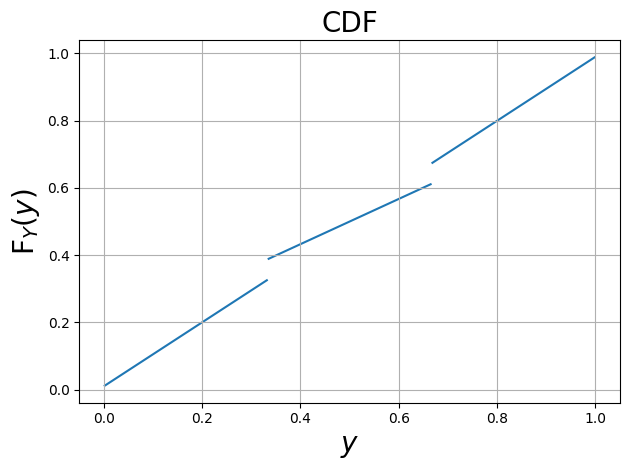

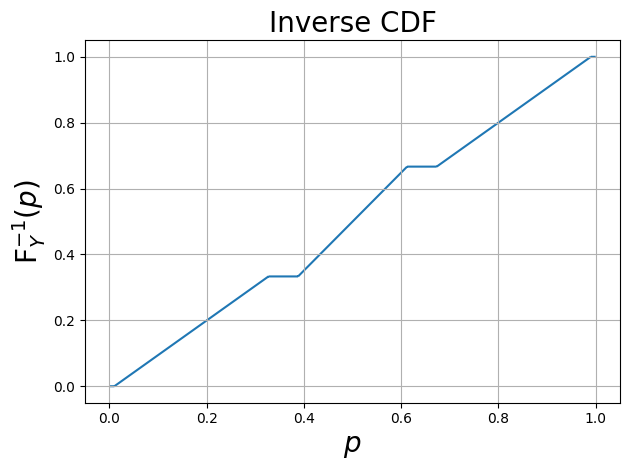

In [9]:
density.plot(function='CDF')
density.plot(function='QDF')

In addition to the fact that the CDF is easily inverted into 'CG1' because the finite element space 'DG1' is chosen for the CDF, this approach also has the advantage that it avoids the need to choose a centroid $p^*$ for the jumps between elements in the CDF where one value of $y$ is associated with multiple values of $p = \mathsf{F}(y)$. This is because letting the dofs of the CDF directly discretise the QDF as opposed to choosing an equispaced mesh bypasses this difficulty. Nevertheless, it can be shown that this approach is consistent with choosing the center of mass.